# Melanoma Detection Assignment

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

-actinic keratosis

-basal cell carcinoma

-dermatofibroma

-melanoma

-nevus

-pigmented benign keratosis

-seborrheic keratosis

-squamous cell carcinoma

-vascular lesion

<div style="text-align: center;">
<img src= "https://github.com/zyper26/Skin-Cancer-ISIC/blob/main/All_Images.png?raw=true" title ="Dataset Example" style='width: 1000px;'>
</div>

# Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

# Importing Skin Cancer Data

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Defining the path for train and test images
root_path = '/content/gdrive/MyDrive/CNN'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

# Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(data_dir_train, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(type(class_names), class_names)


<class 'list'> ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

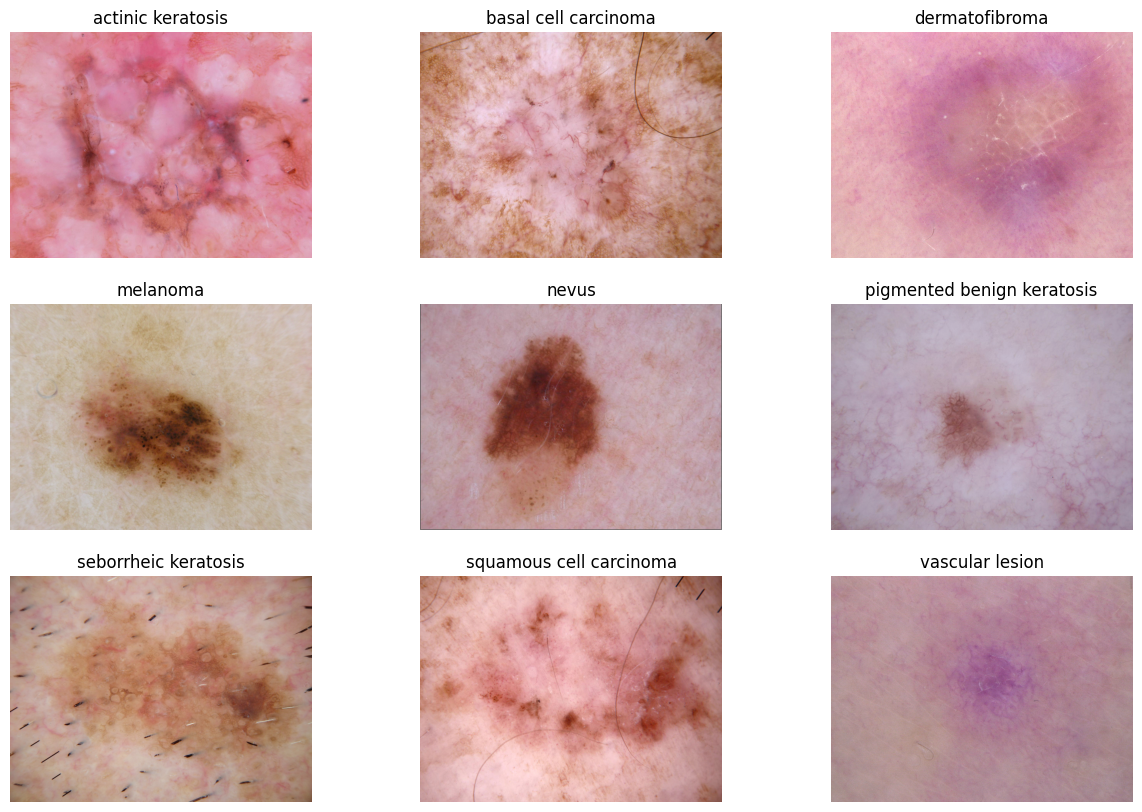

In [12]:
### Visualizing the training data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [13]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


Check the configuration of gpu and use gpu.

In [14]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

# Using data augmentation

In [15]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

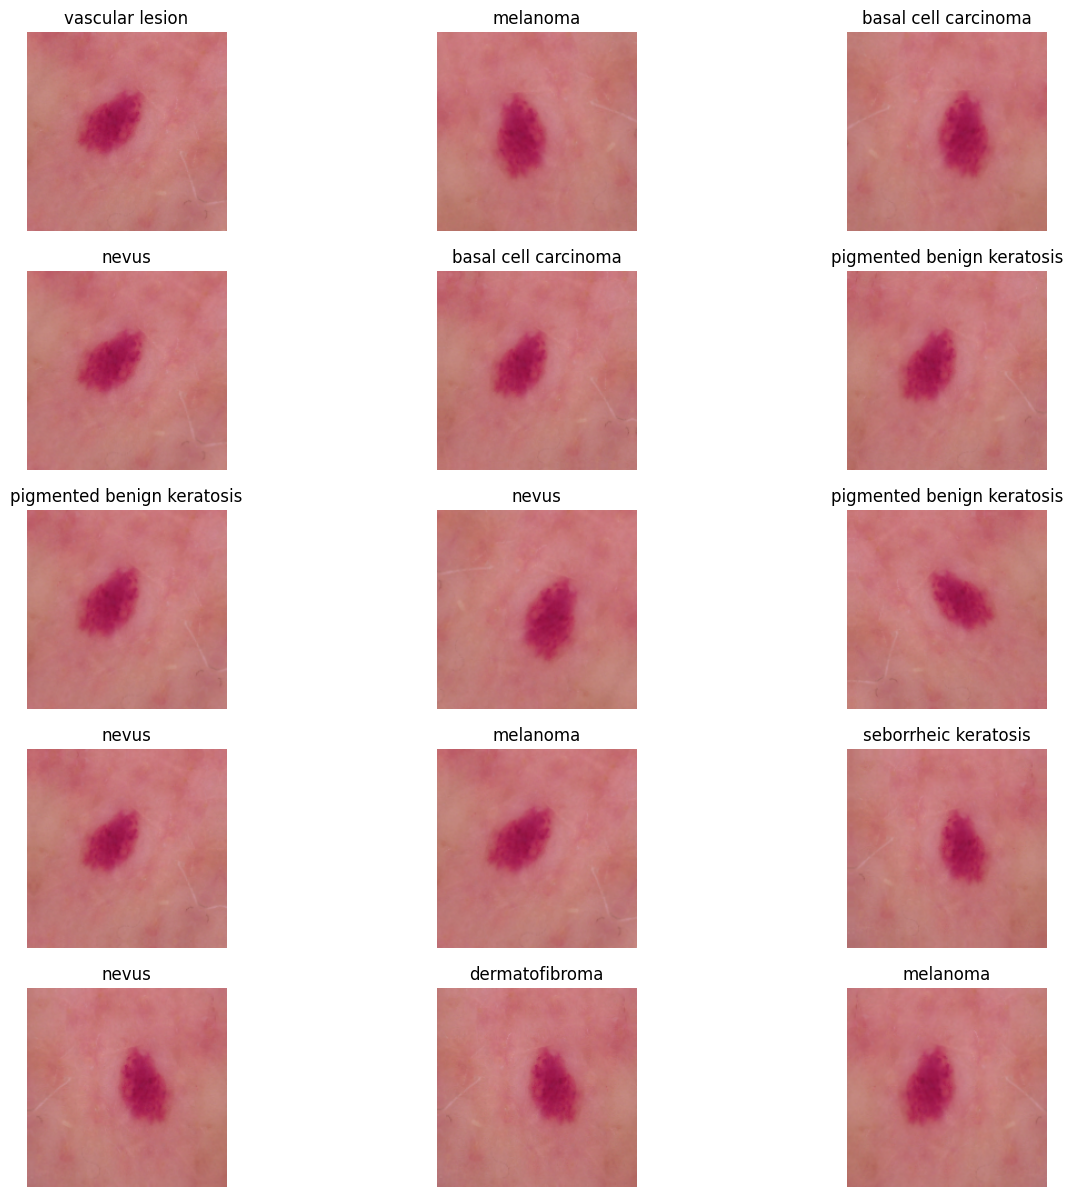

In [17]:
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

# Create the model, compile and train the model


```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                        

### Training the model

In [21]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 53s 720ms/step - loss: 1.9501 - accuracy: 0.2706 - val_loss: 1.7425 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6682 - accuracy: 0.4079 - val_loss: 1.6396 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5480 - accuracy: 0.4453 - val_loss: 1.5355 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5040 - accuracy: 0.4570 - val_loss: 1.5349 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3797 - accuracy: 0.5173 - val_loss: 1.3854 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3362 - accuracy: 0.5346 - val_loss: 1.3792 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3046 - accuracy: 0.5458 - val_loss: 1.4238 - val_accuracy: 0.4922
Epoch 8/20


# Visualizing the results

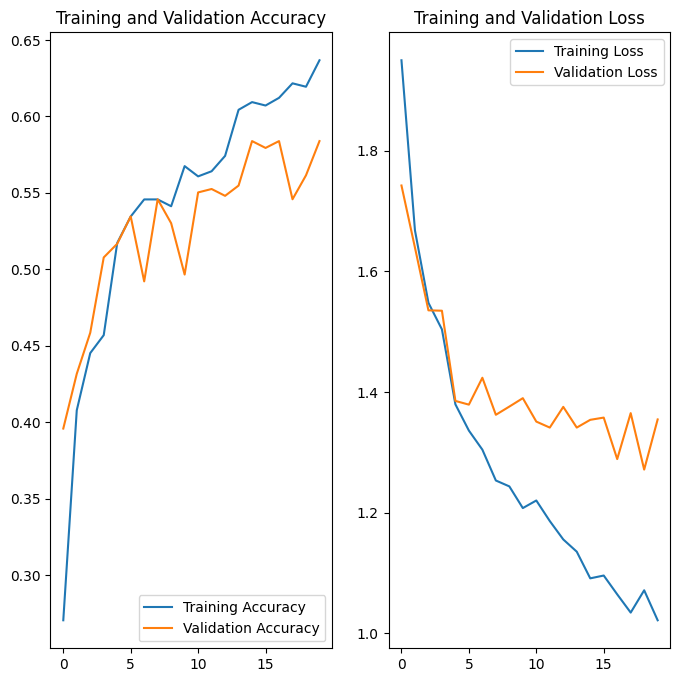

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

These results show the training and validation loss and accuracy values for a neural network model with 20 epochs. The model seems to be improving with each epoch as the training loss and validation loss are decreasing over time. However, the accuracy scores are not very high, indicating that the model is not performing very well.

The model starts with a training loss of 1.95 and a training accuracy of 0.27 in the first epoch. By the end of the 20th epoch, the training loss has decreased to 1.02 and the training accuracy has increased to 0.64. On the validation set, the model starts with a loss of 1.74 and an accuracy of 0.40, and ends with a loss of 1.35 and an accuracy of 0.58.

The validation accuracy is not improving significantly after the 14th epoch. This could mean that the model is starting to overfit to the training data, and not generalizing well to new data. To improve the performance of the model, the architecture of the network could be modified or the dataset could be augmented to increase the variability of the data.

# Distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [24]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


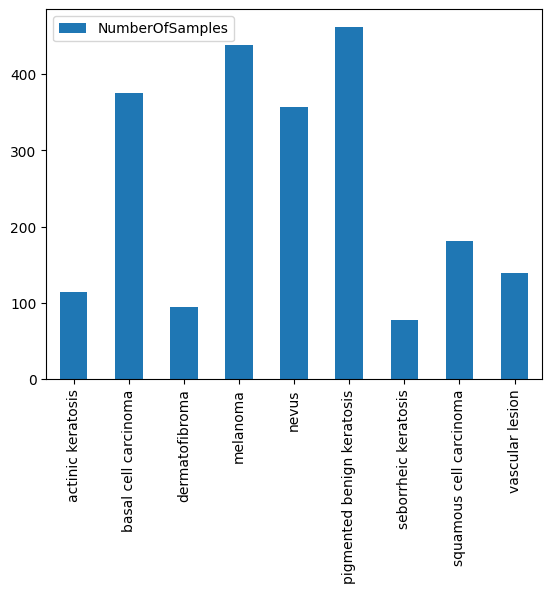

In [25]:
class_df.plot.bar()
plt.show()

# Rectify the class imbalance
#### Python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import Augmentor

In [28]:
path_to_training_dataset = "/content/gdrive/MyDrive/CNN/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.



Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F51D00397C0>: 100%|██████████| 500/500 [00:29<00:00, 17.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F51BAFBB2E0>: 100%|██████████| 500/500 [00:37<00:00, 13.25 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F51BAFCCBE0>: 100%|██████████| 500/500 [00:26<00:00, 18.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F51BAFBDFD0>: 100%|██████████| 500/500 [01:59<00:00,  4.19 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F51DAF151C0>: 100%|██████████| 500/500 [01:43<00:00,  4.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F51BAF94910>: 100%|██████████| 500/500 [00:22<00:00, 22.71 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F51D00FCA60>: 100%|██████████| 500/500 [00:48<00:00, 10.32 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F51D8574310>: 100%|██████████| 500/500 [00:22<00:00, 22.45 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F51BAFCEC70>: 100%|██████████| 500/500 [00:20<00:00, 24.00 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [34]:
import glob as gb

path_list = [x for x in gb.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list


['/content/gdrive/MyDrive/CNN/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_2200199f-e993-4714-bcc0-311cf5842544.jpg',
 '/content/gdrive/MyDrive/CNN/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_ed2ca4f1-23b9-4bed-95b5-0381222b7936.jpg',
 '/content/gdrive/MyDrive/CNN/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_06674610-9f80-48b8-8efd-1220f6fe2c98.jpg',
 '/content/gdrive/MyDrive/CNN/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_73c1d8bf-ce7b-45b1-9218-b7f2cfcf2276.jpg',
 '/content/gdrive/MyDrive/CNN/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_468e5d40-42a4-44ec-8a44-7c27cde90d99.jpg',
 '/content/gdrive/MyDrive/CNN/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032404.jpg_9c3d3650-6424-427f-8cdb-1990436e0372.jpg',
 '/content/gdrive/MyDrive/CNN/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026702.jpg_9dd1cd6

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in gb.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new


['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [38]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [40]:
new_df['Label'].value_counts()

actinic keratosis             500
pigmented benign keratosis    500
seborrheic keratosis          500
nevus                         500
basal cell carcinoma          500
squamous cell carcinoma       500
melanoma                      500
vascular lesion               500
dermatofibroma                500
Name: Label, dtype: int64

# Train the model on the data created using Augmentor

In [42]:
output_dir ="/content/gdrive/MyDrive/CNN/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [44]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create your model (make sure to include normalization)

In [45]:
num_classes = 9

# Model - Rescaling -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

#### Compile your model (Choose optimizer and loss function appropriately)

In [46]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_4 (Activation)   (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

#### Train your model

In [48]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 38s 64ms/step - loss: 2.0401 - accuracy: 0.2569 - val_loss: 1.7893 - val_accuracy: 0.3415
Epoch 2/30
169/169 [==============================] - 5s 28ms/step - loss: 1.6206 - accuracy: 0.3835 - val_loss: 1.6032 - val_accuracy: 0.4150
Epoch 3/30
169/169 [==============================] - 5s 32ms/step - loss: 1.4063 - accuracy: 0.4764 - val_loss: 1.3684 - val_accuracy: 0.5234
Epoch 4/30
169/169 [==============================] - 5s 28ms/step - loss: 1.2242 - accuracy: 0.5486 - val_loss: 1.2580 - val_accuracy: 0.5293
Epoch 5/30
169/169 [==============================] - 5s 28ms/step - loss: 1.1076 - accuracy: 0.5892 - val_loss: 1.1628 - val_accuracy: 0.5731
Epoch 6/30
169/169 [==============================] - 5s 29ms/step - loss: 0.9751 - accuracy: 0.6398 - val_loss: 1.1399 - val_accuracy: 0.5679
Epoch 7/30
169/169 [==============================] - 5s 28ms/step - loss: 0.8619 - accuracy: 0.6814 - val_loss: 0.9596 - val_accuracy: 0.652

#### Visualize the model results

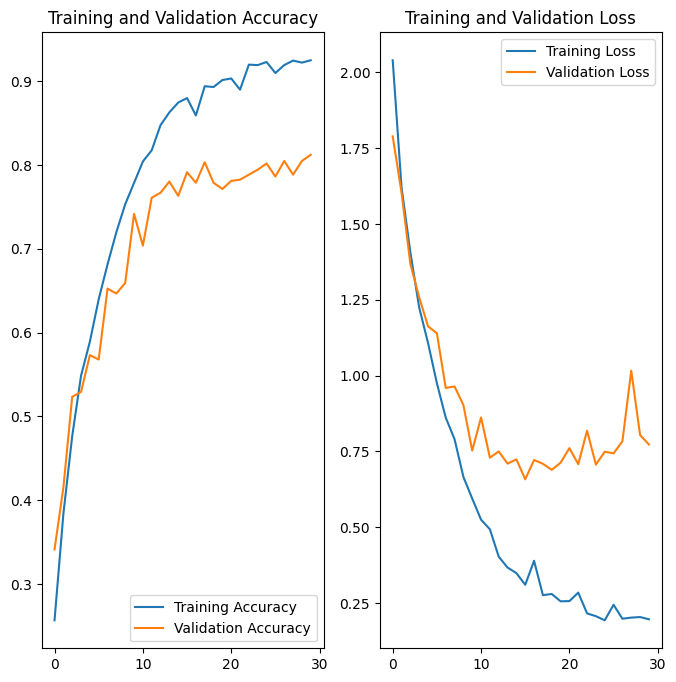

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The training logs provided show the loss and accuracy metrics for the training and validation sets at each epoch during training of a neural network model. The model seems to be a classification model, as it reports both the loss and accuracy metrics. In the first epoch, the model has a training loss of 2.0401 and a training accuracy of 0.2569. The validation loss and accuracy are 1.7893 and 0.3415, respectively.

During the subsequent epochs, the model's training loss decreases while the training accuracy increases, indicating that the model is improving. The validation loss and accuracy also improve for the first few epochs but then plateau, indicating that the model may be starting to overfit the training data.

Overall, the model seems to be performing reasonably well, with a final training accuracy of 0.9032 and a validation accuracy of 0.8156 in the last epoch. However, more analysis is needed to determine if the model is suitable for its intended purpose.

We still have a overfitting model but we have much better accuracy than previous models.At end we have around 10% accuuracy difference between training and validation data.
Class rebalance helped us in getting better accuracy. We can reduce the overfitting by having a deeper model or add a data augmentation layer before it.

# Model with data augmentation and using Augmentor dataset

In [50]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [51]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense

model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [52]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_8 (Activation)   (None, 180, 180, 16)      0         
                                                      

In [54]:
epochs = 50
# Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 8s 28ms/step - loss: 1.9323 - accuracy: 0.2650 - val_loss: 1.6189 - val_accuracy: 0.4269
Epoch 2/50
169/169 [==============================] - 5s 28ms/step - loss: 1.5194 - accuracy: 0.4253 - val_loss: 1.3347 - val_accuracy: 0.4744
Epoch 3/50
169/169 [==============================] - 5s 28ms/step - loss: 1.3673 - accuracy: 0.4835 - val_loss: 1.3007 - val_accuracy: 0.4959
Epoch 4/50
169/169 [==============================] - 5s 27ms/step - loss: 1.3170 - accuracy: 0.5017 - val_loss: 1.2384 - val_accuracy: 0.5323
Epoch 5/50
169/169 [==============================] - 5s 28ms/step - loss: 1.2224 - accuracy: 0.5347 - val_loss: 1.1592 - val_accuracy: 0.5486
Epoch 6/50
169/169 [==============================] - 5s 28ms/step - loss: 1.1696 - accuracy: 0.5562 - val_loss: 1.1049 - val_accuracy: 0.5932
Epoch 7/50
169/169 [==============================] - 5s 28ms/step - loss: 1.1060 - accuracy: 0.5805 - val_loss: 1.0815 - val_accuracy: 0.5857

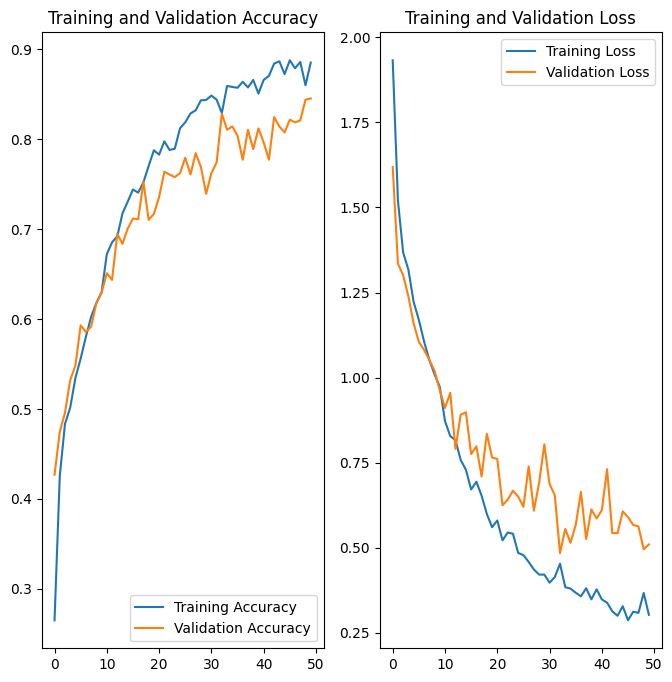

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

This is a neural network model that is being trained on some data. The model have 50 epochs and it has already gone through 21 epochs. For each epoch, there is a training set and a validation set. The model outputs the loss and accuracy for both the training set and the validation set.

In the first epoch, the model had a training loss of 1.9323 and training accuracy of 0.2650. The validation loss was 1.6189 and the validation accuracy was 0.4269. For the second epoch, the training loss was 1.5194 and the training accuracy was 0.4253. The validation loss was 1.3347 and the validation accuracy was 0.4744.

In general, the training loss and training accuracy decrease while the validation loss and validation accuracy increase as the model goes through more epochs. This suggests that the model is improving and becoming better at predicting the data. However, it's important to note that after a certain point, the model may start overfitting to the training data and performing worse on the validation data. Therefore, it's important to monitor the validation loss and accuracy closely to determine when the model starts overfitting.

# Model evaluation

In [56]:
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 118 files belonging to 9 classes.


Predictions:
 [0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1
 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0
 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0
 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1
 1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1
 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1
 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0
 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 0 1]
Labels:
 [1 4 3 5 7 0 7 7 3 6 2 0 1 4 0 5 5 5 1 1 5 4 1 5 5 5 0 0 1 2 4 8]


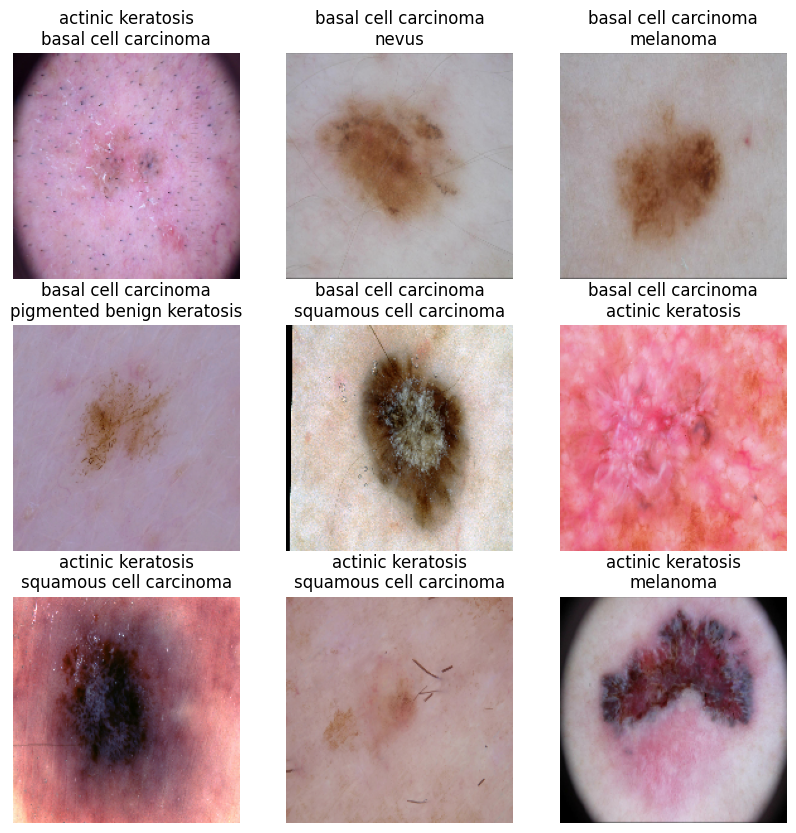

In [57]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")